## Proyecto 4: Sistema de Recomendación

In [1]:
# Importar librerías:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import seaborn as sns
from math import sqrt
import geopandas as gpd
from dateutil.parser import parse 
from scipy.spatial.distance import pdist
from sklearn.metrics.pairwise import cosine_similarity

In [16]:
# Cargar dataset
data = pd.read_csv('OnlineRetail.csv',  encoding='ISO-8859-1')

In [3]:
# Eliminamos colunmas innecesarias
data = data.drop(['Description', 'CustomerID', 'InvoiceNo', 'StockCode'], axis=1)
# Verificamos que no esten las columnas eliminadas
data.columns

Index(['Quantity', 'InvoiceDate', 'UnitPrice', 'Country'], dtype='object')

In [17]:
data = data.loc[(data['Country'] != "Unspecified")] 

In [23]:
# PRUEBAS
#df = df[(df.Quantity > 100)]
#df.Country.sort_values()
#df.Country.value_counts(normalize=True)
#df_paises.Country.value_counts(normalize=True)
#df_paises = df_paises.loc[df_paises['Country'] != "Singapore"] 

# Crear un diccionario con los datos
paises = {'paises': ["Netherlands", "Australia","EIRE", "Ireland","Sweden","France"        
                    "Germany", "Japan", "Spain", "Norway", "Finland", "Switzerland",        
                    "Belgium", "Denmark", "Portugal", "Austria", "Cyprus", "Canada","Italy"]}
#paises = ['Germany', 'France', 'EIRE', 'Netherlands', 'Belgium', 'Switzerland', 'Portugal', 'Australia', 'Norway', 'Italy']             
data_filt = data[data['Country'].isin(paises)]
# Ventas = pd.DataFrame(data_filt)

## Gráficos

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36],
 [Text(0, 0, 'United Kingdom'),
  Text(1, 0, 'France'),
  Text(2, 0, 'Australia'),
  Text(3, 0, 'Netherlands'),
  Text(4, 0, 'Germany'),
  Text(5, 0, 'Norway'),
  Text(6, 0, 'EIRE'),
  Text(7, 0, 'Switzerland'),
  Text(8, 0, 'Spain'),
  Text(9, 0, 'Poland'),
  Text(10, 0, 'Portugal'),
  Text(11, 0, 'Italy'),
  Text(12, 0, 'Belgium'),
  Text(13, 0, 'Lithuania'),
  Text(14, 0, 'Japan'),
  Text(15, 0, 'Iceland'),
  Text(16, 0, 'Channel Islands'),
  Text(17, 0, 'Denmark'),
  Text(18, 0, 'Cyprus'),
  Text(19, 0, 'Sweden'),
  Text(20, 0, 'Austria'),
  Text(21, 0, 'Israel'),
  Text(22, 0, 'Finland'),
  Text(23, 0, 'Bahrain'),
  Text(24, 0, 'Greece'),
  Text(25, 0, 'Hong Kong'),
  Text(26, 0, 'Singapore'),
  Text(27, 0, 'Lebanon'),
  Text(28, 0, 'United Arab Emirates'),
  Text(29, 0, 

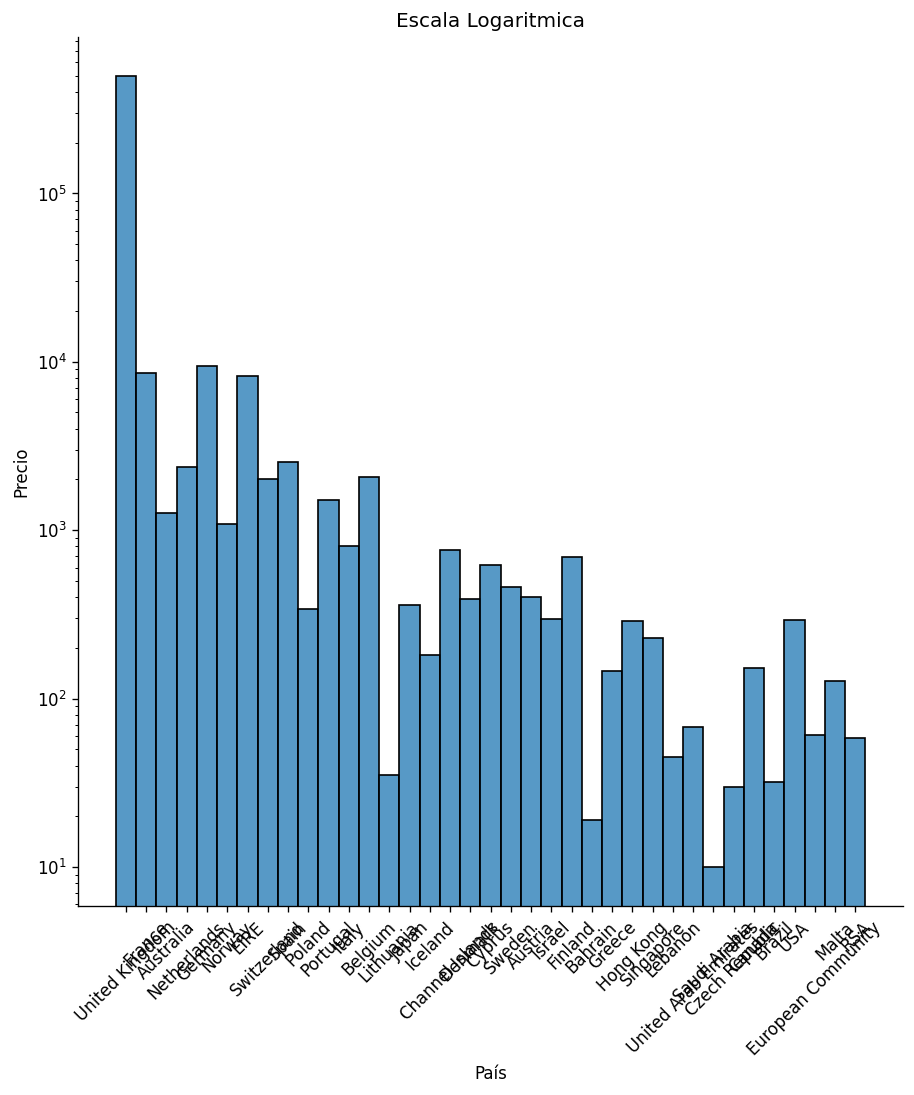

In [5]:
# Matplotlib usa todo el ancho de pantalla:
plt.rcParams.update({'figure.figsize': (10, 8), 'figure.dpi': 120})
figure = sns.displot(data=data, x='Country', height=8 ) 
plt.title("Escala Logaritmica")
plt.xlabel("País")
plt.ylabel("Precio")
plt.yscale('log')
plt.xticks(rotation=45)

In [ ]:
# Pairplot del dataset
sns.pairplot(data)

C:\Users\n_sar\AppData\Local\Temp\ipykernel_1676\1165628841.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

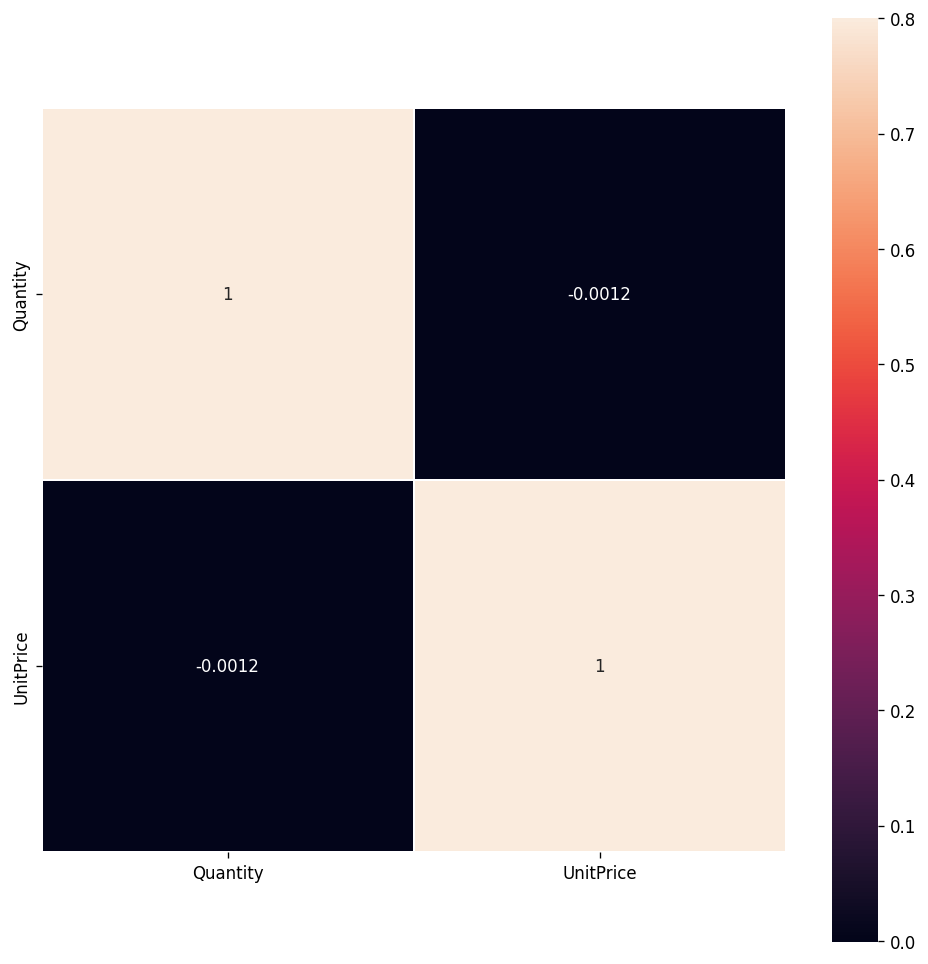

In [10]:
# Mapa de correlaciones
corr = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True)

In [ ]:
titles=' '.join(data.title).lower()
plt.figure(figsize=(15,10))
wordcloud = WordCloud(collocations=True, max_words=500 ).generate(titles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

2. Construir un mapa que muestre número de compras totales por país y otro con número de compras relativas (per capita) por país.

In [6]:
# Lee los datos de los límites de los países
paises_geo_pandas = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Ver el listado completo
pd.set_option('display.max_rows', 200)
paises_geo_pandas.name.sort_values

<bound method Series.sort_values of 0                          Fiji
1                      Tanzania
2                     W. Sahara
3                        Canada
4      United States of America
5                    Kazakhstan
6                    Uzbekistan
7              Papua New Guinea
8                     Indonesia
9                     Argentina
10                        Chile
11              Dem. Rep. Congo
12                      Somalia
13                        Kenya
14                        Sudan
15                         Chad
16                        Haiti
17               Dominican Rep.
18                       Russia
19                      Bahamas
20                 Falkland Is.
21                       Norway
22                    Greenland
23       Fr. S. Antarctic Lands
24                  Timor-Leste
25                 South Africa
26                      Lesotho
27                       Mexico
28                      Uruguay
29                       Brazil
30  

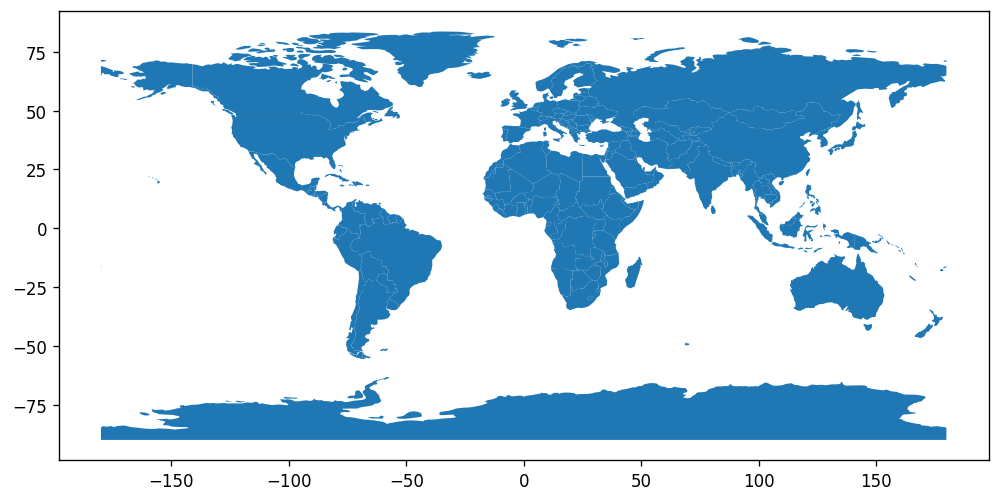

In [7]:
# Verificar si coincide losnombre d elos países del data frame con los del geopandas
#paises_geo_pandas.loc[paises_geo_pandas["name"]=="Iceland"]
# Crea una figura y un eje
fig, ax = plt.subplots(figsize=(10, 6))
# Dibuja los países en el mapa
paises_geo_pandas.plot(ax=ax)
# Muestra el mapa
plt.show()   

In [ ]:
# Unir los datos de los países con los datos de ventas por país
df = paises_geo_pandas.merge(data, left_on='name', right_on='Country')
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 6))
# Dibujar los países en el mapa y colorearlos según las ventas
df.plot(ax=ax, column='Quantity', cmap='Blues', linewidth=0.8, edgecolor='black', legend=True)
# Añadir un título al mapa
ax.set_title('Ventas por país')    
#plt.yscale('log')
plt.show()

3. Analizar los horarios y calendarios de compra, mediante histogramas y estacionalidad.

In [8]:
data.head(5)
#data.sort_values(by=['Country','InvoiceDate','UnitPrice'])
# Agrupar por fecha y país y calcular la suma de los valores
#data = data.groupby(['InvoiceDate', 'Country'])['UnitPrice'].sum()
#data = data.groupby(by="year").sum()

,Quantity,InvoiceDate,UnitPrice,Country
0,6,12/1/2010 8:26,2.55,United Kingdom
1,6,12/1/2010 8:26,3.39,United Kingdom
2,8,12/1/2010 8:26,2.75,United Kingdom
3,6,12/1/2010 8:26,3.39,United Kingdom
4,6,12/1/2010 8:26,3.39,United Kingdom


In [21]:
# Convertir la columna "fecha_hora" a formato de fecha y hora
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
# Separar la fecha y los minutos/segundos en columnas separadas
data['Date'] = data['InvoiceDate'].dt.date
data['minutos_segundos'] = data['InvoiceDate'].dt.time
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,minutos_segundos
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,08:26:00


In [22]:
data = data.drop(['InvoiceDate', 'minutos_segundos'], axis=1)
data.head(2)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01


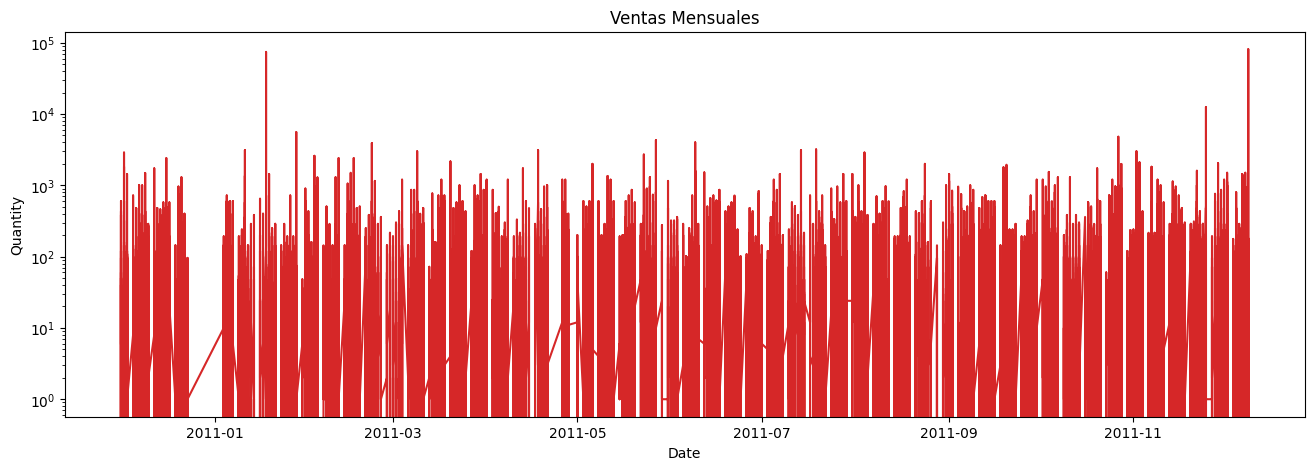

In [12]:
# Ploteamos
def plot_df(data, x, y, title="", xlabel='Date', ylabel='Quantity', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.yscale('log')
    plt.show()
plot_df(data, x=data.fecha, y=data.Quantity, title='Ventas Mensuales')

4. Crear la **Customer-Item Matrix** mediante el método df.pivot_table

In [27]:
#Customer_Item = pd.pivot_table(data, values='Quantity', index=['CustomerID', 'Description'], columns=['Date'], aggfunc=np.sum)
Customer_Item = pd.pivot_table(data, values='Quantity', index=['CustomerID', 'Description'], aggfunc=np.sum)
Customer_Item

Quantity
CustomerID Description                                
12346.0    MEDIUM CERAMIC TOP STORAGE JAR            0
12347.0    3D DOG PICTURE PLAYING CARDS            126
           3D SHEET OF CAT STICKERS                 12
           3D SHEET OF DOG STICKERS                 12
           60 TEATIME FAIRY CAKE CASES              72
...                                                ...
18287.0    STAR T-LIGHT HOLDER WILLIE WINKIE        12
           STRAWBERRY BATH SPONGE                   30
           STRAWBERRY CERAMIC TRINKET BOX           12
           SWISS CHALET TREE DECORATION             48
           TREE T-LIGHT HOLDER WILLIE WINKIE        12

[268933 rows x 1 columns]

5. Crear la **User to User Similarity Matrix** mediante la **distancia del coseno** con la librería sklearn

In [31]:
df_CustomerID = data['CustomerID']
df_CustomerID.head(2)

0    17850.0
1    17850.0
Name: CustomerID, dtype: float64

In [39]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country', 'Date'],
      dtype='object')

In [49]:
# Convertir CustomerID (float) en un array.
CustomerID = pd.DataFrame(data=np.random.randint(0, 1000000, (100,8)),columns=['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country', 'Date'])
nmp=CustomerID.to_numpy()
print(nmp) 
print(type(nmp))

[[470614 122114 787604 202162 871524 742154 489643 504040]
 [942600 770345 205526 316872 554151 984600 135695 219779]
 [877068 615737 687849 428355 923581 727892 230070 251771]
 [936775  40573 313657 815978 228974  13561 649280 116838]
 [163588 518626 431875 902883 124139 319766 811609 438975]
 [605420 707574 114549 597336  25927 350978 821013 230473]
 [619531  52081 914930 288205 445710  66718 462133 597250]
 [721608 799594 561843 677324 925495 672104 770720 623483]
 [156159  52810 134599 236750 474623 988273 296919 777186]
 [816040 317514 830556  90922 562844 243926 972210 223199]
 [300334 549915 124778 539241 454857 121087 597050 803562]
 [110840 654407 362600 324798 788858 944996 279534 367774]
 [657485  12009 398661 965546 488383 476205 575088 160729]
 [ 43654 509457 586498 334929 302919 231615 994078 904528]
 [884357 460024 622794  13021 893832 560690 945771  23041]
 [513513 843522 618930 793005  17035 321709 116249 319144]
 [485756 453443 334992 358658 251864 641337 587834 24325

In [50]:
from scipy.spatial.distance import squareform

In [51]:
distances = pdist(CustomerID, metric="cosine")
cosineDistance = squareform(distances)
cosineDistance

array([[0.        , 0.23913448, 0.09599452, ..., 0.14134437, 0.07678657,
        0.26843388],
       [0.23913448, 0.        , 0.07608962, ..., 0.28539684, 0.16997388,
        0.40827481],
       [0.09599452, 0.07608962, 0.        , ..., 0.13597941, 0.08755575,
        0.27796475],
       ...,
       [0.14134437, 0.28539684, 0.13597941, ..., 0.        , 0.08107799,
        0.2368012 ],
       [0.07678657, 0.16997388, 0.08755575, ..., 0.08107799, 0.        ,
        0.20951592],
       [0.26843388, 0.40827481, 0.27796475, ..., 0.2368012 , 0.20951592,
        0.        ]])

In [52]:
cosineSimilarity = 1 - cosineDistance
cosineSimilarity

array([[1.        , 0.76086552, 0.90400548, ..., 0.85865563, 0.92321343,
        0.73156612],
       [0.76086552, 1.        , 0.92391038, ..., 0.71460316, 0.83002612,
        0.59172519],
       [0.90400548, 0.92391038, 1.        , ..., 0.86402059, 0.91244425,
        0.72203525],
       ...,
       [0.85865563, 0.71460316, 0.86402059, ..., 1.        , 0.91892201,
        0.7631988 ],
       [0.92321343, 0.83002612, 0.91244425, ..., 0.91892201, 1.        ,
        0.79048408],
       [0.73156612, 0.59172519, 0.72203525, ..., 0.7631988 , 0.79048408,
        1.        ]])

In [53]:
cosine_sim = cosine_similarity(CustomerID)
cosine_sim

array([[1.        , 0.76086552, 0.90400548, ..., 0.85865563, 0.92321343,
        0.73156612],
       [0.76086552, 1.        , 0.92391038, ..., 0.71460316, 0.83002612,
        0.59172519],
       [0.90400548, 0.92391038, 1.        , ..., 0.86402059, 0.91244425,
        0.72203525],
       ...,
       [0.85865563, 0.71460316, 0.86402059, ..., 1.        , 0.91892201,
        0.7631988 ],
       [0.92321343, 0.83002612, 0.91244425, ..., 0.91892201, 1.        ,
        0.79048408],
       [0.73156612, 0.59172519, 0.72203525, ..., 0.7631988 , 0.79048408,
        1.        ]])

In [54]:
# Crear matriz dispersa aleatoria
n = 10
density = 0.3
matrix = random(n, n, density=density)
print(matrix.shape)
print("\n")
print(matrix)

NameError: name 'random' is not defined

In [ ]:
# Convertir matriz dispersa a una matriz densa
dense_matrix = matrix.todense()
print(dense_matrix)

# Graficar matriz densa
plt.imshow(dense_matrix, cmap='gray', interpolation='nearest')
plt.show()

# Graficar matriz dispersa
plt.spy(matrix, markersize=5)
plt.show()

6. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por usuario**.

In [55]:
# pip3 install apyori
from apyori import apriori

In [56]:
# Crear un conjunto de datos de ejemplo de transacciones de compra
productos = [['Leche', 'Pan', 'Queso'],
         ['Leche', 'Pan'],
         ['Leche', 'Queso'],
         ['Leche', 'Pan', 'Queso'],
         ['Leche', 'Pan', 'Queso', 'Huevos'],
         ['Leche', 'Pan', 'Huevos']]

# Utilizar el algoritmo Apriori para generar conjuntos de elementos frecuentes y reglas de asociación
conjuntos_frecuentes = list(apriori(productos, min_support=0.2, min_confidence=0.7, min_lift=1.2))

In [57]:
# Imprimir los conjuntos de elementos frecuentes y las reglas de asociación resultantes
print("Conjuntos Frecuentes:")
for conjunto in conjuntos_frecuentes:
    print(conjunto.items)
print("\nReglas de Asociación:")
for conjunto in conjuntos_frecuentes:
    for regla in conjunto.ordered_statistics:
        antecedente = list(regla.items_base)
        consecuente = list(regla.items_add)
        confianza = regla.confidence
        lift = regla.lift
        print(f"{antecedente} -> {consecuente}, confianza = {confianza:.2f}, lift = {lift:.2f}")

Conjuntos Frecuentes:
frozenset({'Huevos', 'Pan'})
frozenset({'Huevos', 'Pan', 'Leche'})

Reglas de Asociación:
['Huevos'] -> ['Pan'], confianza = 1.00, lift = 1.20
['Huevos'] -> ['Pan', 'Leche'], confianza = 1.00, lift = 1.20
['Huevos', 'Leche'] -> ['Pan'], confianza = 1.00, lift = 1.20


7. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por producto** creando previamente la **Item to Item Similarity Matrix**.

8. Obtener las 10 recomendaciones de tipo **basado en contenido** utilizando métricas de texto (Levenshtein o vectorización TF-IDF)

9. Realizar un **market basket analysis** para detectar **bundles** (packs) de productos. Algoritmos de clusterización como K-means podrían detectar los bundles más frecuentes.